In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
import astropy.units as u
import astropy.constants as c
from astropy.visualization import quantity_support

In [5]:
plt.rc('axes', labelsize=14)
plt.rc('figure', titlesize=30)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

In [33]:
def transfer(f,t):
    '''
    t is the integration time of the signal and pedestal levels
    f is the frequency at which the ccd is clocked
    '''
    t = t / 2 # 

    noise_density = 2 * (np.sin((np.pi * f * t).to(u.rad)))**2 / ((np.pi * f * t).to(u.rad))
    return noise_density

def sig_cds(ewn, t, f1, f2):
    '''
    ewn is voltage noise density of white noise
    '''
    t = t / 2 

    return ewn * np.sqrt(1/t + 4*f1*np.log(2) + 4/3 * f2**2 * np.pi**2 * t)

def sig_skipper(n, ewn, t, f1, f2):
    '''
    ewn is voltage noise density of white noise
    '''
    t = t / 2 

    return ewn * np.sqrt(1/t + 4*f1*np.log(2) + 4/3 * f2**2 * np.pi**2 * t) / np.sqrt(n)

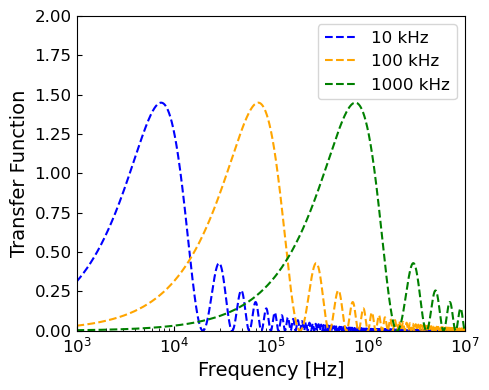

In [26]:
quantity_support()

fig, ax = plt.subplots(1, 1, figsize=(5,4), layout='tight')


freqs = np.logspace(0,10,10000) * u.Hz * u.rad * 2 * np.pi
tau = np.logspace(-9, -3, 10000) * u.s 

int_time_1 = 5.5e-6 * u.s
int_time_2 = 55e-6 * u.s

int_speed_10 = 1/(10*u.kHz)
int_speed_100 = 1/(100*u.kHz)
int_speed_1000 = 1/(1*u.MHz)

ax.plot(freqs, transfer(freqs, int_speed_10), label = '{:.0f}'.format((1/int_speed_10).to(u.kHz)), color = 'blue', ls='--')
ax.plot(freqs, transfer(freqs, int_speed_100), label = '{:.0f}'.format((1/int_speed_100).to(u.kHz)), color = 'orange', ls='--')
ax.plot(freqs, transfer(freqs, int_speed_1000), label = '{:.0f}'.format((1/int_speed_1000).to(u.kHz)), color='green', ls='--')

ax.set_xlabel(r'Frequency [Hz]')
ax.set_ylabel(r'Transfer Function')
ax.legend(loc = 'best')
ax.set_xlim(1e3, 1e7)
ax.set_xscale('log')
ax.set_ylim(0, 2)

ax.tick_params(axis='both', direction='in', which='both')


fig.tight_layout()

plt.savefig('/home/baparker/GitHub/Research/CCDs/cds_transfer_func.png', dpi=250)
plt.show()

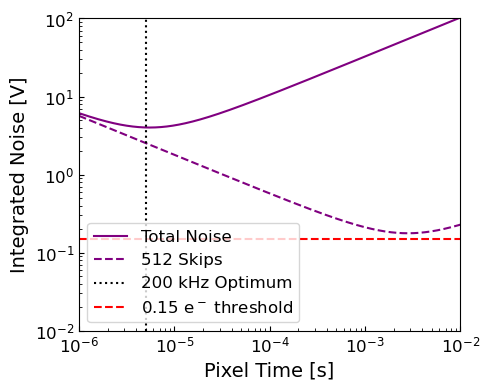

In [35]:
quantity_support()

fig, ax = plt.subplots(1, 1, figsize=(5,4), layout='tight')


freqs = np.logspace(0,10,10000) * u.Hz * u.rad * 2 * np.pi
tau = np.logspace(-9, -2, 10000) * u.s 

wn_floor = 2e-8 * u.V / ((u.Hz)**(1/2))
nc_1f = 100 * u.kHz
nc_1f2 = 100 * u.kHz

skips = 512

ax.plot(tau, sig_cds(wn_floor, tau, nc_1f, nc_1f2) / 5e-6, label='Total Noise', color='purple')
ax.plot(tau * skips, sig_skipper(skips, wn_floor, tau, nc_1f, nc_1f2) / 5e-6, label='512 Skips', color='purple', ls='--')
ax.axvline(1/(200 * u.kHz), label='200 kHz Optimum', color='k', ls=':')
ax.axhline(0.15, color='red', ls='--', label='0.15 e$^-$ threshold')

ax.set_xlabel(r'Pixel Time [s]')
ax.set_ylabel(r'Integrated Noise [V]')
ax.legend(loc = 'best')
ax.set_xlim(1e-6, 1e-2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-2, 1e2)

ax.tick_params(axis='both', direction='in', which='both')

fig.tight_layout()

plt.savefig('/home/baparker/GitHub/Research/CCDs/ccd_integrated_noise.png', dpi=250)
plt.show()

In [30]:
sig_cds(wn_floor, tau, nc_1f, nc_1f2).to(u.V) / (5e-6)

<Quantity [178.89784011, 178.77430932, 178.65086385, ...,  32.47030768,
            32.49265162,  32.51501107] V>

In [29]:
(2 * np.pi * freqs * tau).si

<Quantity [3.94784176e-08, 3.96241443e-08, 3.97704089e-08, ...,
           3.91885700e+08, 3.93332268e+08, 3.94784176e+08] rad>

574-588